In [1]:
import numpy as np
import pandas as pd
import scipy.integrate as int
import scipy.optimize as op
import emcee
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.constants as const
import sys
from astropy.cosmology import wCDM
#from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM

In [2]:
#inputting data (34 data points)
cc_xdata, cc_ydata, cc_yerr = np.loadtxt('/Users/eoin/Documents/Python/Data/cc.txt',usecols=(0,1,2), unpack=True)
#bao_xdata, bao_ydata, bao_yerr = np.loadtxt('/Users/eoin/Documents/Projects/Cosmology/HighZ/bao.dat',usecols=(0,1,2), unpack=True)

In [3]:
def H(z, h0, om):
    return h0*np.sqrt(1-om + om*(1+z)**3)

In [4]:
input_xdata = cc_xdata
input_ydata = cc_ydata
input_yerr = cc_yerr

In [6]:
zmin  = 0; zmax = 2.5;

In [7]:
x = np.logical_and(zmin < input_xdata, input_xdata <= zmax)
y = np.logical_not(x)
xdata = input_xdata[x]
ydata = input_ydata[x]
yerr = input_yerr[x]
cov = np.diag(yerr**2)
len(yerr)

34

In [8]:
def lnlike(u):
    h0 = u[0]
    om = u[1]
    
    cc = -0.5*((ydata-H(xdata, h0, om))**2/yerr**2).sum()
    
#    wm = om*(h0/100)**2
#    cmb = -1/2*(wm - 0.1430)**2/0.00000121
    
    return cc

In [9]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [70, 0.3], bounds = ((0, 200), (0, 1)), options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-15, 'gtol': 1e-05, 'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20})
h0, om = result["x"]
print(h0, om, (h0/100)**2*om)

68.14402786803511 0.320211652490243 0.14869375622154063


In [10]:
# Fisher matrix
print(h0, om)
Q = ydata -H(xdata, h0, om)
DH0Q = -np.sqrt(1-om+om*(1+xdata)**3)
DOMQ = -h0/2*(xdata**3+3*xdata**2+3*xdata)/np.sqrt(1-om+om*(1+xdata)**3)
DH0OMQ = -1/2*(xdata**3+3*xdata**2+3*xdata)/np.sqrt(1-om+om*(1+xdata)**3)
DOM2Q = 1/4*h0*(xdata**3+3*xdata**2+3*xdata)**2/(1-om+om*(1+xdata)**3)**(3/2)
cinv = np.linalg.inv(cov)
F11 = DH0Q.dot(cinv).dot(DH0Q); F12 = 1/2*(DH0OMQ.dot(cinv).dot(Q)+DOMQ.dot(cinv).dot(DH0Q)+DH0Q.dot(cinv).dot(DOMQ)+Q.dot(cinv).dot(DH0OMQ));
F22 = DOMQ.dot(cinv).dot(DOMQ)+1/2*(Q.dot(cinv).dot(DOM2Q)+DOM2Q.dot(cinv).dot(Q))
F = [[F11,F12],[F12,F22]]
h0err, omerr = np.sqrt(np.diag(np.linalg.inv(F))).T
print(h0err, omerr)

68.14402786803511 0.320211652490243
3.0700857965490025 0.05868029068529319


In [11]:
def lnprior(u):
    h0 = u[0]
    om = u[1]

    if 0 <= h0 < 200 and 0 <= om <= 1:
        return 0.0
    return -np.inf

In [12]:
def lnprob(u):
    lp = lnprior(u)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(u)

In [13]:
ndim, nwalkers = 2, 30
pos = [[h0, om] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)    

In [ ]:
sampler.run_mcmc(pos, 100000, progress=True);

/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  7%|▋         | 7221/100000 [00:09<02:03, 753.24it/s]

In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[314.43845727 402.75295306]


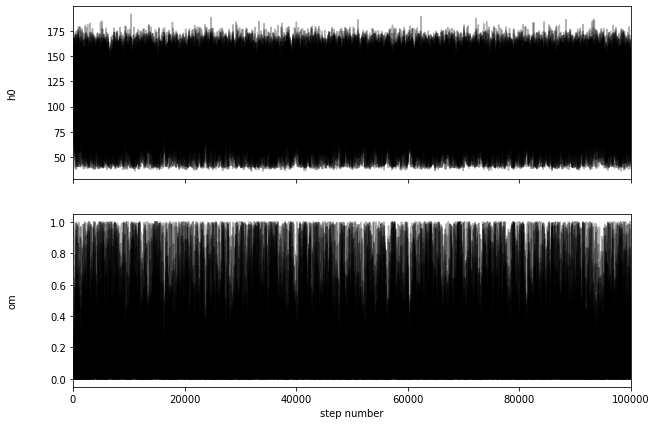

In [16]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["h0", "om"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
samples = sampler.chain[:, 5000:, :].reshape((-1, ndim))

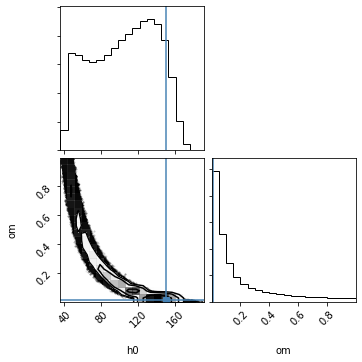

In [18]:
import corner
fig = corner.corner(samples, labels=["h0", "om"], truths=[h0, om])
#fig.savefig("QSO_OHD_CMBprior_zmin07.png")

In [19]:
flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
print(flat_samples.shape)

(189990, 2)


In [20]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    #err = 1/2*(q[0]+q[1])
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #txt = "\mathrm{{{2}}} = {0:.2f}\pm{{{1:.2f}}}"
    #txt = txt.format(mcmc[1], err, labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
#np.savetxt("CC_zmin1_MCMCchain.txt", flat_samples)
# the output of the MCMC chain
flat_samples

array([[7.44525992e+01, 2.53649819e-01],
       [1.32781293e+02, 3.02430155e-02],
       [6.29553735e+01, 4.12542469e-01],
       ...,
       [1.47359212e+02, 1.33554159e-02],
       [7.39426478e+01, 2.93181563e-01],
       [6.10665529e+01, 4.54661349e-01]])

In [26]:
# evaluating the chi^2 for each entry in the MCMC chain, note factor of 2
output = []
for x in flat_samples: 
    output.append([x[0], x[1], 2*nll([x[0], x[1]])])

output = np.array(output)
output

array([[7.44525992e+01, 2.53649819e-01, 8.32934355e+00],
       [1.32781293e+02, 3.02430155e-02, 5.02664983e+00],
       [6.29553735e+01, 4.12542469e-01, 8.78113988e+00],
       ...,
       [1.47359212e+02, 1.33554159e-02, 4.67790661e+00],
       [7.39426478e+01, 2.93181563e-01, 8.38543727e+00],
       [6.10665529e+01, 4.54661349e-01, 8.96813174e+00]])

In [27]:
h0_min, om_min, chi_sq_min = output[output[:,2]==np.min(output[:,2])][0]
print(h0_min, om_min, chi_sq_min)

150.35008358448061 0.009847519551170724 4.6684024484931665


In [28]:
#np.savetxt("MCMCchain_DP.txt", output)

In [29]:
#temp = np.loadtxt("MCMCchain_DP.txt")
H0, OM, CHI = output.T
len(H0)

189990

In [30]:
# first we analyse H0, I restrict attention to H0 values in our chain
h0bins = np.linspace(H0.min(), H0.max(), 200)
bin_size = np.diff(h0bins)[0]
print(H0.min(), H0.max(), bin_size)
h0bins

36.32824918358381 189.39196083148553 0.7691643801402108


array([ 36.32824918,  37.09741356,  37.86657794,  38.63574232,
        39.4049067 ,  40.17407108,  40.94323546,  41.71239984,
        42.48156422,  43.2507286 ,  44.01989298,  44.78905737,
        45.55822175,  46.32738613,  47.09655051,  47.86571489,
        48.63487927,  49.40404365,  50.17320803,  50.94237241,
        51.71153679,  52.48070117,  53.24986555,  54.01902993,
        54.78819431,  55.55735869,  56.32652307,  57.09568745,
        57.86485183,  58.63401621,  59.40318059,  60.17234497,
        60.94150935,  61.71067373,  62.47983811,  63.24900249,
        64.01816687,  64.78733125,  65.55649563,  66.32566001,
        67.09482439,  67.86398877,  68.63315315,  69.40231753,
        70.17148191,  70.94064629,  71.70981067,  72.47897505,
        73.24813943,  74.01730381,  74.78646819,  75.55563257,
        76.32479695,  77.09396133,  77.86312571,  78.63229009,
        79.40145447,  80.17061885,  80.93978323,  81.70894761,
        82.47811199,  83.24727637,  84.01644075,  84.78

In [31]:
# exporting middle of bin and exp(-delta chi^2/2) - see 2203.16285
chi_min = []
length = 0
for x in h0bins[1:]:
    y = np.logical_and( x-bin_size <= H0, H0 <= x)
    if len(H0[y]) != 0:
        length = length + len(H0[y])
        minimum = CHI[y].min()
#        print(x, minimum, np.exp(-1/2*(minimum-chi_sq_min)))
        chi_min.append([x-bin_size/2, np.exp(-1/2*(minimum-chi_sq_min))])
    
chi_min = np.array(chi_min)
length

189990

In [32]:
xdata = chi_min[:,0]; ydata = chi_min[:,1];

In [33]:
#len(xdata)
#np.full(len(xdata), 2*bin_size)

In [34]:
#def delta_chi2(x, a, b):
#    return a*(x-h0_min)**2+b*(x-h0_min)**3

#def R(x, a, b):
#    return np.exp(-1/2*delta_chi2(x, a, b))

#popt, pcov = op.curve_fit(delta_chi2, xdata, ydata, p0= [0.1, 0.1], sigma = np.diag(np.full(len(xdata),2*bin_size)**2),absolute_sigma=False)
#a, b = popt

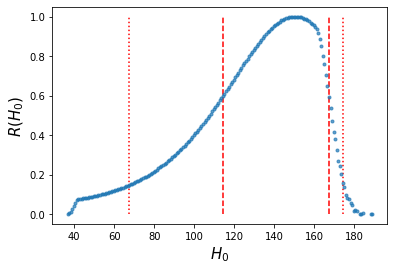

In [71]:
plt.plot(xdata, ydata,'.', alpha=0.7)
#plt.plot(xdata, delta_chi2(xdata,*popt))
plt.ylabel('$R(H_0)$', fontsize=15)
plt.xlabel('$H_0$', fontsize=15)
plt.vlines(167.47077599748957, 0, 1, 'r', linestyle='dashed')
plt.vlines(114.39843376781509, 0, 1, 'r', linestyle='dashed')
plt.vlines(67.4794065792623, 0, 1, 'r', linestyle='dotted')
plt.vlines(174.39325541875144, 0, 1, 'r', linestyle='dotted')
#plt.savefig('H0_R_zmin1.png', dpi=300)
plt.show()

In [36]:
#total_area = int.quad(R, H0.min(), H0.max(), args=(a,b))[0]
#print(total_area)

#threshold=0.61
#def func(x):
#    return delta_chi2(x, a, b) +2*np.log(threshold)


#sol = op.fsolve(func, [60, 70])
#sol

In [37]:
#int.quad(R, sol[0], sol[1], args=(a,b))[0]/total_area

In [38]:
total_area = int.simps(ydata, xdata)
total_area

67.27724286087316

In [70]:
threshold = 0
z = ydata > threshold
int.simps(ydata[z], xdata[z])/total_area

1.0

In [67]:
print(h0_min, h0_min-xdata[z].min(), xdata[z].max()-h0_min, xdata[z].min(), xdata[z].max())

150.35008358448061 82.87067700521831 24.043171834270822 67.4794065792623 174.39325541875144


In [72]:
# now let's switch to Omega_m
ombins = np.linspace(OM.min(), OM.max(), 200)
bin_size = np.diff(ombins)[0]
print(OM.min(), OM.max(), bin_size)

3.1233333283586795e-07 0.999989890930221 0.005025073259280845


In [73]:
chi_min = []
for x in ombins[1:]:
    y = np.logical_and( x-bin_size < OM, OM <= x)
    if len(OM[y]) != 0:
        minimum = CHI[y].min()
        print(x, minimum)
        chi_min.append([x-bin_size/2, np.exp(-1/2*(minimum-chi_sq_min))])
    
chi_min = np.array(chi_min)

0.005025385592613681 4.689538354146758
0.010050458851894525 4.6684024484931665
0.01507553211117537 4.668454125062267
0.020100605370456215 4.688832497282168
0.02512567862973706 4.737555132252297
0.030150751889017904 4.8080366259834815
0.03517582514829875 4.889144456674874
0.040200898407579594 4.979639849982647
0.04522597166686044 5.077168341682008
0.05025104492614128 5.1779858159541226
0.05527611818542213 5.282034368570658
0.06030119144470297 5.38478064540184
0.06532626470398381 5.489123851353709
0.07035133796326466 5.593049604636698
0.07537641122254551 5.690302118394627
0.08040148448182635 5.789910281322089
0.08542655774110719 5.887577825800046
0.09045163100038804 5.98305897128424
0.0954767042596689 6.071718260229472
0.10050177751894973 6.162220845157924
0.10552685077823057 6.249180546720179
0.11055192403751142 6.331927990149009
0.11557699729679227 6.414014420320245
0.12060207055607311 6.492614576723386
0.12562714381535395 6.571312975133105
0.13065221707463479 6.64431585591764
0.135677

In [74]:
xdata = chi_min[:,0]; ydata = chi_min[:,1];

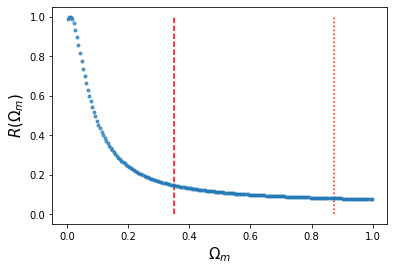

In [114]:
# An unnormalised distribution peaked on h0_min by construction
plt.plot(xdata, ydata, '.', alpha=0.7)
plt.xlabel('$\Omega_m$', fontsize=15)
plt.ylabel('$R(\Omega_m)$', fontsize=15)
plt.vlines(0.3492429038533516, 0, 1, 'r', linestyle='dashed')
#plt.vlines(0.0025128489629732582, 0, 1, 'r', linestyle='dashed')
plt.vlines(0.8718505228185593, 0, 1, 'r', linestyle='dotted')
#plt.vlines(174.39325541875144, 0, 1, 'r', linestyle='dotted')
#plt.savefig('om_R_zmin1.png', dpi=300)
plt.show()

In [79]:
area = int.simps(ydata, xdata)
area

0.19771663379728643

In [123]:
threshold = 0.1449
z = ydata > threshold
int.simps(ydata[z], xdata[z])/area

0.6785688065716855

In [127]:
print(om_min, om_min-xdata[z].min(), xdata[z].max()-om_min)

0.009847519551170724 0.007334670588197466 0.33939538430218086
